In [22]:
# handle imports
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import streamlit as st
st.set_option('deprecation.showPyplotGlobalUse', False)

In [18]:
### Exploratory data analysis ###
df = pd.read_csv("../data.csv", sep=";")

# Must map categorical values to numbers or else the heatmap won't work
statusMap = {'Dropout': 1, 'Enrolled': 2, 'Graduate': 3}
# df = df[df.Target != 'Enrolled']
df['Target'].value_counts()

df['Target'] = df['Target'].replace(statusMap)
# df['Age at enrollment'].min()


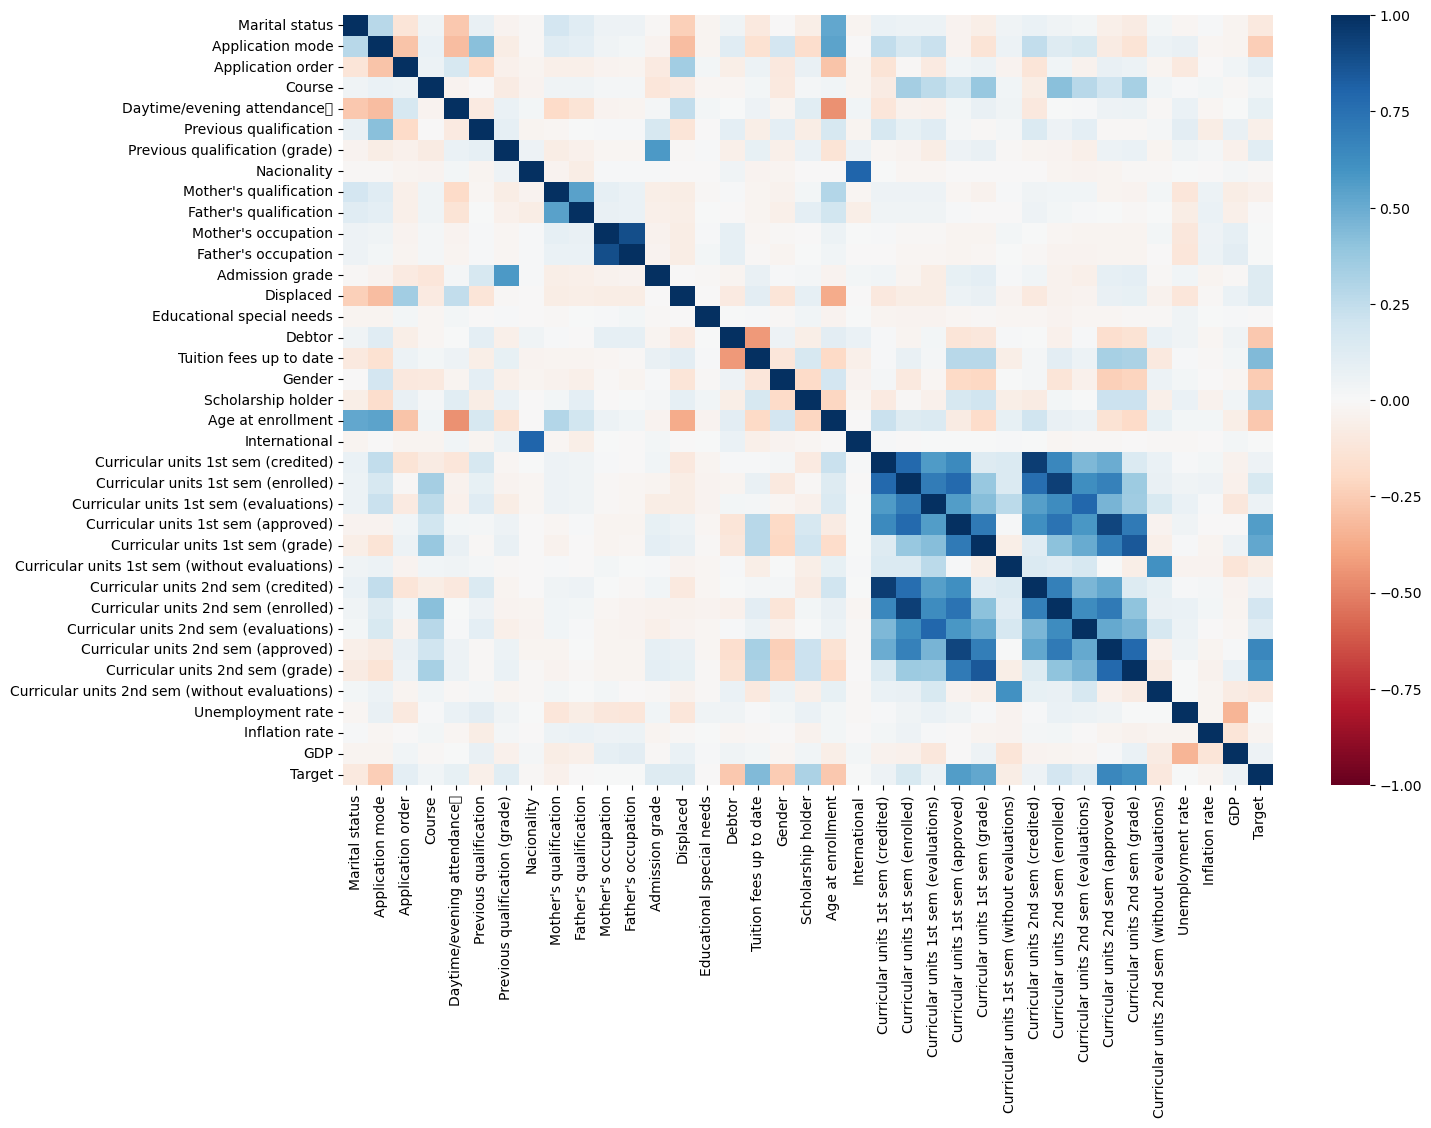

In [24]:
plt.figure(figsize = (15,10))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, center=0, annot=False, cmap= 'RdBu')

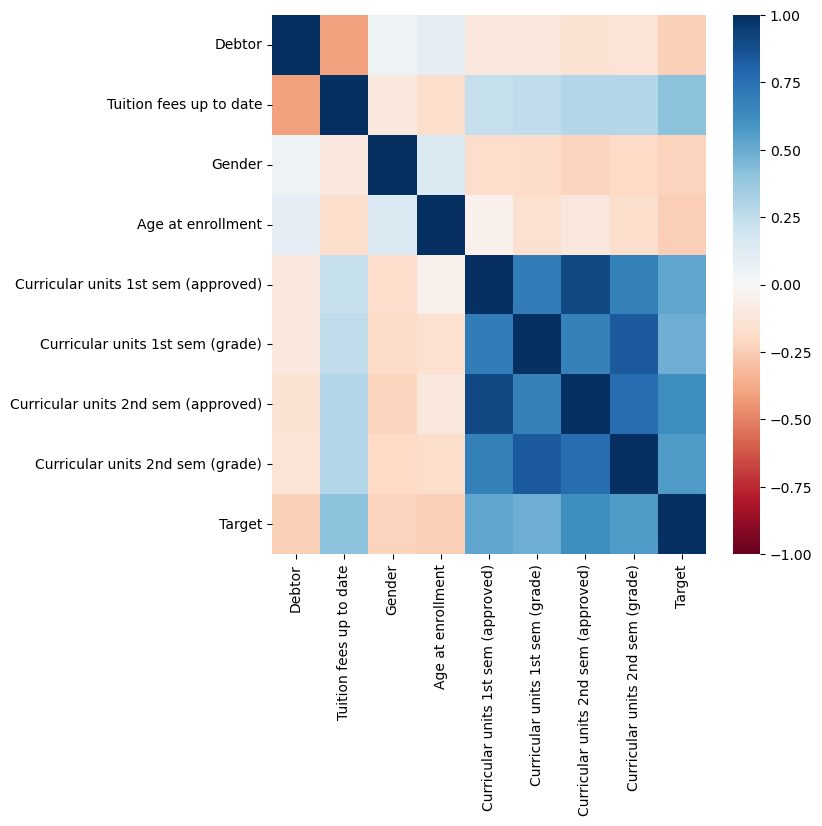

In [19]:
# Check if the columns exist in the dataframe before dropping them
columns_to_drop = [
    'Unemployment rate', 'Inflation rate', 'GDP', 'International',
    'Course', 'Nacionality', 'Application order', 'Application mode',
    "Mother's occupation", "Father's occupation",
    'Educational special needs', "Previous qualification (grade)",
    "Admission grade", "Previous qualification", "Daytime/evening attendance	",
    "Mother's qualification", "Father's qualification",
    "Curricular units 1st sem (credited)", "Curricular units 1st sem (enrolled)",
    "Curricular units 1st sem (evaluations)", "Curricular units 1st sem (without evaluations)",
    "Curricular units 2nd sem (credited)", "Curricular units 2nd sem (enrolled)",
    "Curricular units 2nd sem (evaluations)", "Curricular units 2nd sem (without evaluations)",
    "Displaced", "Marital status", "Scholarship holder"
]
df.drop(columns=columns_to_drop, inplace=True)
# display(df)
plt.figure(figsize=(7,7))
heatmap_after = sns.heatmap(df.corr(), vmin=-1, vmax=1, center=0, annot=False, cmap='RdBu')

<Axes: xlabel='Gender', ylabel='Target'>

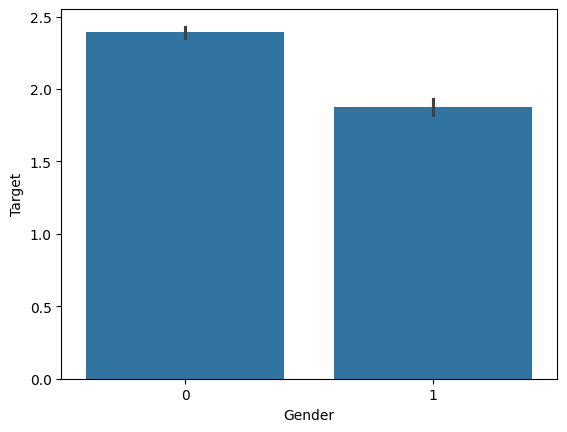

In [27]:
# do some static vis analyzing the higher correlated factors
# X_0 = female, X_1 = male | y_1 = dropout, y_2 = enrolled, y_3 = graduate
# catplot = sns.catplot(data=df, x="Target", y="Age at enrollment", hue="Gender")
sns.barplot(data=df, x="Gender", y="Target")

              precision    recall  f1-score   support

           1       0.75      0.68      0.71       444
           2       0.57      0.52      0.55       439
           3       0.65      0.76      0.70       443

    accuracy                           0.65      1326
   macro avg       0.65      0.65      0.65      1326
weighted avg       0.66      0.65      0.65      1326



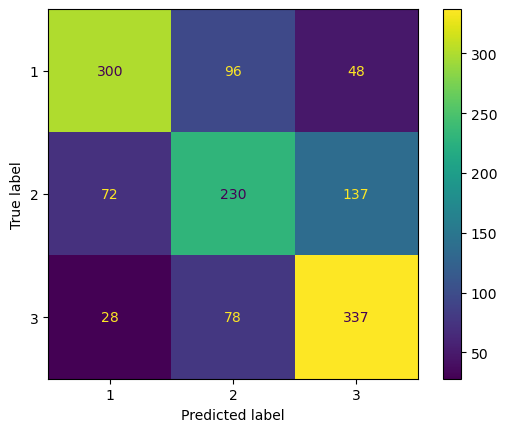

In [20]:
X = df.drop(columns=['Target'])
y = df['Target']
# display(df)
# Balance the dataset, as there are almost twice as many graduates than drop outs
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X, y)

# Split the data into training and testing sets (80 percent training, 20 percent testing)
X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, test_size=0.2, random_state=42)

# Scale data subsets
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Create a multinomial logistic regression model
logreg = LogisticRegression(multi_class="multinomial", solver='lbfgs', max_iter=1000)

# Fit the model on the training data
logreg.fit(X_train, y_train)
joblib.dump(logreg, "logistic-reg")
# Make predictions on the test data
predictions = logreg.predict(X_test)


print(classification_report(y_test, predictions))
cm = confusion_matrix(y_test, predictions)
ConfusionMatrixDisplay(cm,display_labels=logreg.classes_).plot()
plt.grid(False)

              precision    recall  f1-score   support

           1       0.80      0.68      0.74       444
           2       0.59      0.54      0.56       439
           3       0.63      0.79      0.70       443

    accuracy                           0.67      1326
   macro avg       0.68      0.67      0.67      1326
weighted avg       0.68      0.67      0.67      1326



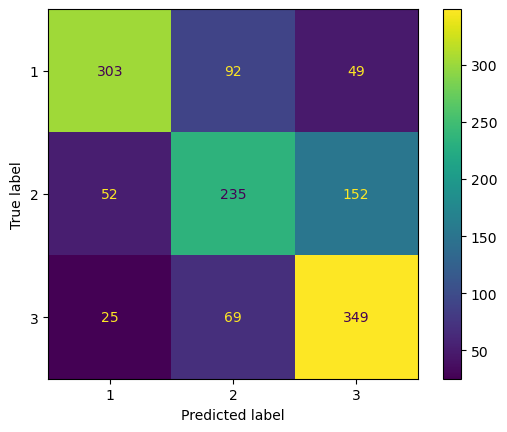

In [8]:
# use SVM, rbf kernel
# Split the data into training and testing sets (80 percent training, 20 percent testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a binomial logistic regression model
svc_rbf = SVC(kernel='rbf')

scaler = StandardScaler()
scaler.fit(X_train)

Z_svm_train = scaler.transform(X_train)
Z_svm_test = scaler.transform(X_test)

svc_rbf.fit(Z_svm_train, np.asarray(y_train))
joblib.dump(svc_rbf, "svc_rbf")
predictions = svc_rbf.predict(Z_svm_test)

print(classification_report(y_test, predictions))

cm = confusion_matrix(y_test, svc_rbf.predict(Z_svm_test))
ConfusionMatrixDisplay(cm,display_labels=svc_rbf.classes_).plot()
plt.grid(False)

              precision    recall  f1-score   support

           1       0.78      0.80      0.79       444
           2       0.73      0.73      0.73       439
           3       0.74      0.73      0.73       443

    accuracy                           0.75      1326
   macro avg       0.75      0.75      0.75      1326
weighted avg       0.75      0.75      0.75      1326



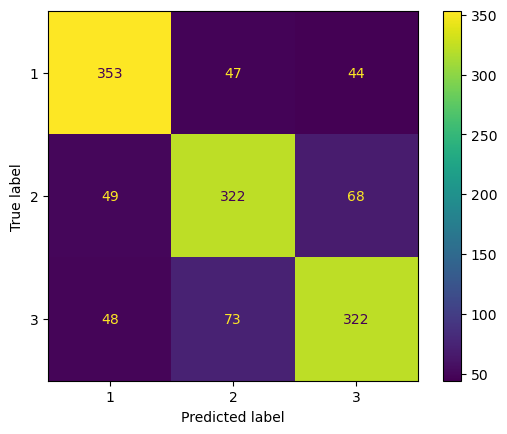

In [30]:
# Making a neural net to try and increase accuracy
mlp = MLPClassifier(solver='lbfgs', alpha=1e-40, hidden_layer_sizes=(50, 40), random_state=1, max_iter=2000)
mlp.fit(X_train, y_train)
joblib.dump(mlp, "nn-reg")
predictions = mlp.predict(X_test)

print(classification_report(y_test, predictions))
cm = confusion_matrix(y_test, predictions)
ConfusionMatrixDisplay(cm,display_labels=mlp.classes_).plot()
plt.grid(False)